## データサイエンス特論2024: Lecture14 LLM時代のデータサイエンスとは
### イントロ：LocalなLLMでcsvデータを分析してみる。

>【注意】この環境は2024.5月に動作確認したものであり、利用するソフトのバージョンアップで使えなくなる可能性が高いことに注意。

ここでは、LLM(大規模言語モデル）を使って、csvファイルに記録されたデータを分析する例を示します。最先端のLLMの活用方法として、データに直接質問(query)するパターンと、データ分析エージェント(Agent)を使って分析させるパターンの２種類を紹介します。

OpenAIなどの有料の高性能LLMを使わなくても、最近はオープンソースのLLMでもcsvデータ分析ぐらいはできるものが増えてきました。試してみると面白と思います。

最初に、オープンソースのLLMを利用する例を、最後に参考までに、OpenAIを使う場合を示します。


オープンソースLLMを利用する方法として、ここでは、いったんローカル環境(といってもcolaboratory計算機ですが）にLLMをダウンロードして利用するローカルLLMを利用します。情報が外部に漏れることを気にする方はローカルLLMは便利ですね。ここではOllamaというソフトウエアを用いて、オープンソースのLLMをローカル環境にダウンロードして活用します。

OpenAIのAPIアカウントをお持ちの方は、gpt3やgpt4をLLMとして使うと、違いが実感できるはずです。

llamaindexの pandas query engineを使います。

- https://docs.llamaindex.ai/en/stable/examples/query_engine/pandas_query_engine/?h=titanic#analyzing-the-titanic-dataset




###  利用環境
- [Ollama](https://ollama.com/)
- [llama_index](https://docs.llamaindex.ai/en/stable/)
- [langchain](https://python.langchain.com/docs/get_started/introduction)

以下gemini様の説明より
> LlamaIndexとLangChainは、どちらも大規模言語モデル（LLM）を活用するための強力なライブラリですが、<略>
> LlamaIndexはQAシステムやデータインデックス作成に特化し、初心者でも扱いやすい簡潔さが魅力。一方、LangChainは汎用性の高いLLMフレームワークで、複雑なタスクや高度なカスタマイズにも対応。それぞれの強みを活かし、目的に合ったツールを選ぶことで、LLM活用の可能性が大きく広がります。

以下copilot様より、、
> Ollamaは、ユーザーがローカル環境で大規模な言語モデルを簡単に動作させることができるツールです。LLama2やCode Llamaなどのモデルを実行することができ、カスタマイズや独自のモデルの作成も可能です

## 2. Ollamaの設定
ここでは、ollamaを colaboratoryの環境にダウンロードしてインストールします、インストールは１回でいいです。

In [1]:
!curl -fsSL https://ollama.com/install.sh | sh
!sudo apt install -y neofetch

>>> Downloading ollama...
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  caca-utils chafa fonts-droid-fallback fonts-noto-mono fonts-urw-base35
  ghostscript gsfonts imagemagick imagemagick-6-common imagemagick-6.q16 jp2a
  libchafa0 libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9
  libgs9-common libid3tag0 libidn12 libijs-0.35 libimlib2 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10 libp

マシンスペックを確認します。

In [ ]:
!neofetch

            .-/+oossssoo+/-.
        `:+ssssssssssssssssss+:`
      -+ssssssssssssssssssyyssss+-
    .ossssssssssssssssssdMMMNysssso.
   /ssssssssssshdmmNNmmyNMMMMhssssss/
  +ssssssssshmydMMMMMMMNddddyssssssss+
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/
  +sssssssssdmydMMMMMMMMddddyssssssss+
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
root@eb2329e9853d 
----------------- 
OS: Ubuntu 22.04.3 LTS x86_64 
Host: Google Compute Engine 
Kernel: 6.1.58+ 
Uptime: 4 mins 
Packages: 1300 (dpkg) 
Shell: bash 5.1.16 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (2) @ 2.000GHz 
GPU: NVIDIA Tesla T

### ollama serverを起動

colab環境にてollamaを使うためのサーバーを起動します。このサーバーは、外部から(pythonなどから）ollamaが管理するllmにアクセスるためのサーバーでもあります。

ローカルLLMを使っていて、時々以下のようなエラーが出る場合は、ollama severが停止している可能性があるので、↓のセルをもう一度起動しましょう。

> ConnectError: [Errno 99] Cannot assign requested address

In [2]:
import subprocess
import time

# Start ollama as a backrgound process
command = "nohup ollama serve&"

# Use subprocess.Popen to start the process in the background
process = subprocess.Popen(command,
                            shell=True,
                           stdout=subprocess.PIPE,
                           stderr=subprocess.PIPE)
print("Process ID:", process.pid)
time.sleep(5)  # Makes Python wait for 5 seconds

Process ID: 1527


ollama serveが動いているかどうかのチェック

In [3]:
!ollama list

NAME	ID	SIZE	MODIFIED 


### ここでollamaでモデルをダウンロードしてrunします。


- 途中で落ちると、ollamaのプロセスが落ちるだけなので、そこだけ再起動すればよい、HDDにpullした結果が残っている？ので、再起動すると、すでにpullしたものはそのまま使えます。

```
# これはコードとして書式設定されます
ollama run mistral
ollama run llama3
ollama run phi3
```



8B(ビリオン、80億パラメター）モデルならば、Colab環境でどうにか動きます。

とりあえず、mistralが優秀なのでこれを使います、他のllmも試すとよいと思います。

In [4]:
OLLAMA_MODEL='gemma:7b'
OLLAMA_MODEL='mistral'
#OLLAMA_MODEL='phi3'
#OLLAMA_MODEL='llama3'
#OLLAMA_MODEL='wizardlm2'

# Set it at the OS level
import os
os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

mistral


以下では、"run"コマンドにより、指定したローカルLLMをダウンロードして、実行しています。一度ダウンロードすると、セッションが終了するまでずっと使えます。

In [5]:
!ollama run $OLLAMA_MODEL "Explain AI in one line"

pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏    0 B/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕▏ 128 KB/4.1 GB                  pulling manifest 
pulling ff82381e2bea...   0% ▕

In [11]:
!pip install --quiet -U langchain langchainhub langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.8 MB/s eta 0:00:00


ちゃんと動くかどうかを、確かめます。

In [12]:
from langchain_community.chat_models import ChatOllama

#OLLAMA_MODEL='mistral'
llm = ChatOllama(model=OLLAMA_MODEL)

llm.invoke("Who are you?")

AIMessage(content=' I am a Large Language Model trained by Mistral AI.', response_metadata={'model': 'mistral', 'created_at': '2024-05-29T12:25:52.168442904Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 572635972, 'load_duration': 1452624, 'prompt_eval_count': 6, 'prompt_eval_duration': 81127000, 'eval_count': 13, 'eval_duration': 367020000}, id='run-d8e20a2b-b876-472f-b1f0-7637139dc73d-0')

# ここから本番です。

In [13]:
!pip install llama-index llama-index-experimental llama-index-llms-ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.1 MB/s eta 0:00:00


## まずは、簡単なDataFrame に対して、質問(query)を投げるパターンでの利用です。
- llamaindexというLLMを活用するpython パッケージを利用しています。
- llamaindexから、バックグラウンドで動いている、Ollamaモデルに接続する形でLLMを利用できます。


In [14]:
import logging
import sys
from IPython.display import Markdown, display

import pandas as pd
from llama_index.experimental.query_engine import PandasQueryEngine


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [15]:
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama

Settings.llm = Ollama(model=OLLAMA_MODEL, request_timeout=30.0)

もっとも簡単な例で、DataFrameに対する質問をしてみます。

In [16]:
# Test on some sample data
df = pd.DataFrame(
    {
        "city": ["Toronto", "Tokyo", "Berlin"],
        "population": [2930000, 13960000, 3645000],
    }
)

In [17]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [18]:
response = query_engine.query(
    "What is the name of the city with the highest population?",
)

> Pandas Instructions:
```
 df['city'][df['population'].idxmax()]
```
> Pandas Output: Tokyo


## ここから、いよいよtitanicに

In [19]:
!wget 'https://raw.githubusercontent.com/jerryjliu/llama_index/main/docs/docs/examples/data/csv/titanic_train.csv' -O 'titanic_train.csv'

--2024-05-29 12:26:40--  https://raw.githubusercontent.com/jerryjliu/llama_index/main/docs/docs/examples/data/csv/titanic_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57726 (56K) [text/plain]
Saving to: ‘titanic_train.csv’

titanic_train.csv   100%[===================>]  56.37K  --.-KB/s    in 0.008s  

2024-05-29 12:26:41 (6.81 MB/s) - ‘titanic_train.csv’ saved [57726/57726]



In [20]:
df = pd.read_csv("./titanic_train.csv" )
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [22]:
response = query_engine.query(
    "What is the correlation between survival and age?",
)

> Pandas Instructions:
```
 df['survived'].corr(df['age'])
```
> Pandas Output: -0.07722109457217761


sqrtがないとかいってエラーになりる場合もありますが、何回か動かしているとうまく計算できるかも。

In [23]:
response = query_engine.query(
    "whats the square root of the average age?" ,
)

> Pandas Instructions:
```
 df['age'].mean().sqrt()
```
> Pandas Output: There was an error running the output as Python code. Error message: 'numpy.float64' object has no attribute 'sqrt'


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/llama_index/experimental/query_engine/pandas/output_parser.py", line 54, in default_output_processor
    output_str = str(safe_eval(module_end_str, global_vars, local_vars))
  File "/usr/local/lib/python3.10/dist-packages/llama_index/experimental/exec_utils.py", line 159, in safe_eval
    return eval(__source, _get_restricted_globals(__globals), __locals)
  File "<string>", line 1, in <module>
AttributeError: 'numpy.float64' object has no attribute 'sqrt'


In [24]:
#agent.run('what is the most survived group? what is the opposite?')
response = query_engine.query(
    "what is the most survived group? what is the opposite?",
)

> Pandas Instructions:
```
 df.groupby('survived').size().idxmax(), df.groupby('survived').size().min()
```
> Pandas Output: (0, 342)


## agentでやってみる。

> Agentsは、「言語モデルに渡されたツールを用いて、モデル自体が次にどのようなアクションを取るかを決定、実行、観測し、完了するまで繰り返す機能」です。

引用：[LangChain Agentsとは？【Tools・Agents・Toolkits・Agent Executor】](https://zenn.dev/umi_mori/books/prompt-engineer/viewer/langchain_agents)

In [25]:
!pip install langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 4.8 MB/s eta 0:00:00


In [26]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_community.chat_models import ChatOllama

agent = create_pandas_dataframe_agent( ChatOllama(model=OLLAMA_MODEL,timeout=30), df, verbose=True)

解説： agentでは、pythonを実行するエンジンpython_repl_astを使いながら、LLMが考え(Thought)、アクションする(Action)様子が見えます。

例えば以下の実行例では、ageの平均の平方根を求めるのに
- python_replをつかって、dataframeからageの平均を求める
- 平方根を求めるのに math.sqrtを利用する
- （なぜか）小数点２桁までまるめて答える

が順に実行される様子がわかります。、

```
> Entering new AgentExecutor chain...
 Thought: I need to find the average age first, and then calculate the square root of that value.
Action: python_repl_ast
Action Input: `import math; df['age'].mean()`29.69911764705882 I now need to find the square root of the average age.

Action: python_repl_ast
Action Input: `import math; math.sqrt(df['age'].mean())`5.449689683556195 Final Answer: The square root of the average age is approximately 5.45.

> Finished chain.
The square root of the average age is approximately 5.45.
```



In [27]:
agent.run("whats the square root of the average age?")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
 Thought: To find the average age, I will use the `mean()` function on the 'age' column of the dataframe `df`. Then, to calculate the square root, I'll need to import the math module and call its sqrt function.
Action: python_repl_ast
Action Input: `import math; (df['age'].mean()) ** 0.5`5.449689683556195 I now know the final answer
Final Answer: The square root of the average age is approximately 5.45 (rounded to two decimal places)

> Finished chain.


'The square root of the average age is approximately 5.45 (rounded to two decimal places)'

In [28]:
agent.run('what is the most survived group? what is the opposite?')



> Entering new AgentExecutor chain...
 Thought: To find out the most survived group, I will first filter the dataframe for passengers who survived (i.e., `survived==1`) and then count the number of rows in this filtered dataframe. Similarly, to find the least survived group, I will count the number of rows where the survival status is 0 (`survived==0`).

Action: python_repl_ast
Action Input: `filtered_df_1 = df[df['survived'] == 1] ; filtered_df_0 = df[df['survived'] == 0] ; print(len(filtered_df_1)) ; print(len(filtered_df_0))`342
549
 The most survived group is 549 passengers. The opposite, which means the least survived group, would be the number of passengers who did not survive (died during the sinking). Since we know that 549 survived, we can find the number of deceased passengers by subtracting the survivors from the total number of passengers.

Final Answer: The least survived group consists of 1306 - 549 = 757 passengers (who did not survive).

> Finished chain.


'The least survived group consists of 1306 - 549 = 757 passengers (who did not survive).'

In [31]:
agent.run("what is the most survived group? what is the opposite? igonore 'survived' ")



> Entering new AgentExecutor chain...
 Thought: To find out the most and least surviving groups, I need to count the number of survivors in each group based on the 'pclass' column. Then I can identify the maximum and minimum counts.

Action: python_repl_ast
Action Input: `df['pclass'].value_counts()`pclass
3    491
1    216
2    184
Name: count, dtype: int64

ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: ` The most survived group is '3' with 491 passengers. The opposite would be the least surviving group, which in this case is '2' with 184 passengers.`

あまりむつかしいことはできない



> Entering new AgentExecutor chain...
 Thought: I need to create new columns for the age groups and then aggregate the dataframe based on these new columns. After that, I will plot a pie chart using matplotlib.

Action: python_repl_ast
Action Input:
```python
df['age_group'] = np.where(df['age'] < 15, '0-14', np.where(df['age'].between(15,60), '15-60', df['age'] >= 60))
df_grouped = df.groupby('age_group').size()
```

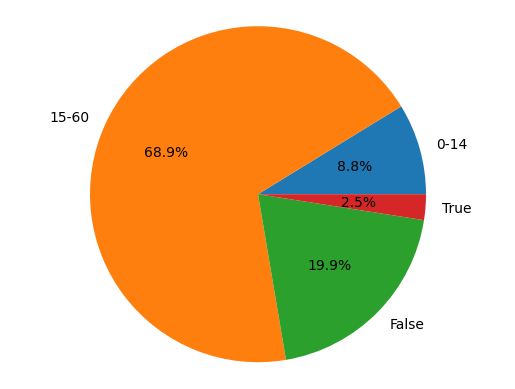

 I now have three age groups in the dataframe and have grouped the data by these new columns. The next step is to plot a pie chart using matplotlib.

Action: python_repl_ast
Action Input:
```python
import matplotlib.pyplot as plt
df_grouped.plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()
``` I have plotted a pie chart with the given age groups and it is displayed on the screen.

Final Answer: The pie chart has been drawn with the three age groups (0-14, 15-60, and >=60) as specified. To view the plot, you should see the resulting pie chart on your screen using matplotlib.

> Finished chain.


'The pie chart has been drawn with the three age groups (0-14, 15-60, and >=60) as specified. To view the plot, you should see the resulting pie chart on your screen using matplotlib.'

In [32]:
agent.run("make three age groupes:  age <15, 15=<age<60<, age>=60. draw pie chart with legend for these age groupe")

# ご参考：OpenAIでやる場合

【注意】OpenAIのアカウントをもち、API_KEYを取得済みの人は、↓のセルでは、以下のようにやってみてください。

```
os.environ["OPENAI_API_KEY"] = XXXXXXX
openai.api_key = os.environ["OPENAI_API_KEY"]
```



In [33]:
#OpenAIの場合
import os
import openai
from google.colab import userdata
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass()

openai.api_key = os.environ["OPENAI_API_KEY"]

··········


In [34]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI

Settings.llm =  OpenAI(temperature=0.1,  model="gpt-3.5-turbo-instruct")

In [35]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,age_group
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15-60
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,15-60
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15-60
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,15-60
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,15-60


In [36]:
query_engine = PandasQueryEngine(df=df, verbose=True)

In [37]:
response = query_engine.query(
    "What is the correlation between survival and age?",
)

> Pandas Instructions:
```
 df['survived'].corr(df['age'])
```
> Pandas Output: -0.07722109457217761


In [38]:
response = query_engine.query(
    "what is the most survived group? what is the opposite?",
)

> Pandas Instructions:
```
 df['survived'].value_counts().idxmax()
```
> Pandas Output: 0


In [39]:
!pip install langchain_openai

In [40]:
from langchain_openai import OpenAI

agent = create_pandas_dataframe_agent( OpenAI(temperature=0), df, verbose=True)

In [42]:
agent.run('what is the most survived group? what is the opposite?')



> Entering new AgentExecutor chain...
Thought: I need to group the dataframe by the "survived" column and then find the maximum value.
Action: python_repl_ast
Action Input: df.groupby("survived").max()TypeError: '>=' not supported between instances of 'float' and 'str'I need to convert the "survived" column to a numeric type before grouping.
Action: python_repl_ast
Action Input: df["survived"] = pd.to_numeric(df["survived"]) Now I can group by "survived" and find the maximum value.
Action: python_repl_ast
Action Input: df.groupby("survived").max()TypeError: '>=' not supported between instances of 'float' and 'str' I need to convert the "age" column to a numeric type as well.
Action: python_repl_ast
Action Input: df["age"] = pd.to_numeric(df["age"]) Now I can group by "survived" and "age" and find the maximum value.
Action: python_repl_ast
Action Input: df.groupby(["survived", "age"]).max()TypeError: '>=' not supported between instances of 'float' and 'str' I need to convert the "fare

'Agent stopped due to iteration limit or time limit.'

In [43]:
agent.invoke("whats the square root of the average age?")



> Entering new AgentExecutor chain...
Thought: I need to calculate the average age first, then take the square root of it.
Action: python_repl_ast
Action Input: df['age'].mean()29.6991176470588229.69911764705882 is the average age.
Action: python_repl_ast
Action Input: math.sqrt(df['age'].mean())NameError: name 'math' is not definedI need to import the math library to use the sqrt function.
Action: python_repl_ast
Action Input: import math I have now imported the math library.
Action: python_repl_ast
Action Input: math.sqrt(df['age'].mean())5.4496896835561955.449689683556195 is the square root of the average age.
Final Answer: 5.449689683556195

> Finished chain.


{'input': 'whats the square root of the average age?',
 'output': '5.449689683556195'}



> Entering new AgentExecutor chain...
Thought: I need to create a new column in the dataframe that categorizes the age into three groups. Then I can use the value_counts() function to get the count of each group and plot a pie chart.
Action: python_repl_ast
Action Input: df['age_group'] = pd.cut(df['age'], bins=[0, 15, 60, np.inf], labels=['<15', '15-60', '>=60'])NameError: name 'np' is not definedI need to import the numpy library to use the np.inf value.
Action: python_repl_ast
Action Input: import numpy as npI can now use the np.inf value in the cut function.
Action: python_repl_ast
Action Input: df['age_group'] = pd.cut(df['age'], bins=[0, 15, 60, np.inf], labels=['<15', '15-60', '>=60'])I now have a new column in the dataframe with the age groups.
Action: python_repl_ast
Action Input: df['age_group'].value_counts()age_group
15-60    609
<15       83
>=60      22
Name: count, dtype: int64 I can now plot a pie chart using the value counts.
Action: python_repl_ast
Action Input: df[

'A pie chart with legend showing the count of passengers in each age group.'

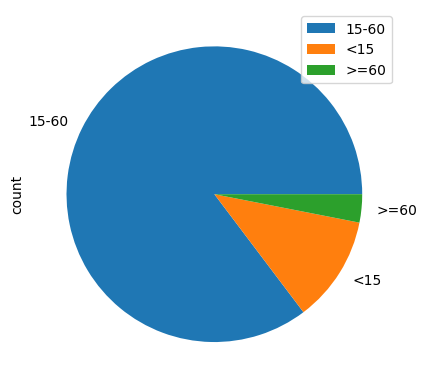

In [44]:
agent.run("make three age groupes:  age <15, 15=<age<60<, age>=60. draw pie chart with legend for these age groupe")

In [45]:
agent.run("make cross summery table for PClass and suvived. show the table")



> Entering new AgentExecutor chain...
Thought: I need to use the pandas groupby function to group the data by PClass and then use the sum function to get the total number of survivors for each PClass.
Action: python_repl_ast
Action Input: df.groupby('pclass')['survived'].sum()pclass
1    136
2     87
3    119
Name: survived, dtype: int64I need to use the pandas pivot_table function to create a cross summary table with PClass as the index and Survived as the columns.
Action: python_repl_ast
Action Input: pd.pivot_table(df, index='pclass', columns='survived', aggfunc='count')          age      age_group      cabin      embarked      fare      name  \
survived    0    1         0    1     0    1        0    1    0    1    0   
pclass                                                                      
1          64  122        64  122    59  117       80  134   80  136   80   
2          90   83        90   83     3   13       97   87   97   87   97   
3         270   85       270   85

'A cross summary table for PClass and Survived has been created and displayed.'



> Entering new AgentExecutor chain...
Thought: I need to use the pandas `crosstab` function to create a cross summary table, and then use a plotting library like matplotlib to create a 3D chart with a legend.
Action: python_repl_ast
Action Input: crosstab(df['pclass'], [df['sex'], df['survived']])NameError: name 'crosstab' is not definedI need to import the pandas library to use the `crosstab` function.
Action: python_repl_ast
Action Input: import pandas as pd Now that I have imported pandas, I can use the `crosstab` function.
Action: python_repl_ast
Action Input: pd.crosstab(df['pclass'], [df['sex'], df['survived']])sex      female     male    
survived      0   1    0   1
pclass                      
1             3  91   77  45
2             6  70   91  17
3            72  72  300  47 Now I need to use a plotting library to create a 3D chart with a legend.
Action: python_repl_ast
Action Input: import matplotlib.pyplot as plt Now that I have imported matplotlib, I can use the `scat

 I need to add a legend to the plot.
Action: python_repl_ast
Action Input: plt.legend()No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
Legend I now know the final answer.
Final Answer: To make a cross summary table for PClass, sex, and survived, and draw a 3D chart with a legend, I would use the pandas `crosstab` function to create the table and the matplotlib `scatter` function to create the 3D chart with a legend.

> Finished chain.


'To make a cross summary table for PClass, sex, and survived, and draw a 3D chart with a legend, I would use the pandas `crosstab` function to create the table and the matplotlib `scatter` function to create the 3D chart with a legend.'

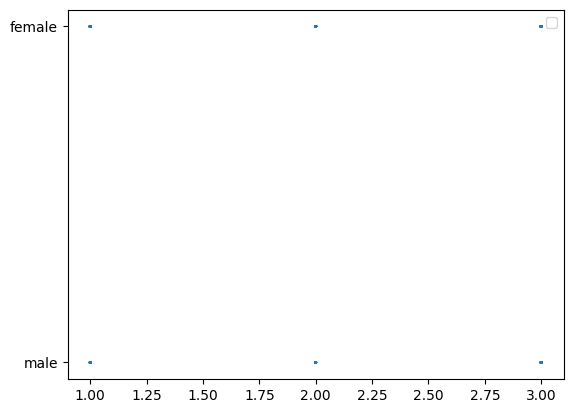

In [ ]:
agent.run("make cross summery table for PClass, sex,m and suvived. draw  3 dimensions  chart with legend")

In [46]:
agent.run("do you have any logical explanation for that female passengers have more suvival rate than male?")



> Entering new AgentExecutor chain...
Thought: I should filter the dataframe to only include female passengers and then calculate the survival rate for them.
Action: python_repl_ast
Action Input: df[df['sex'] == 'female']['survived'].mean()0.7420382165605095I now know the survival rate for female passengers.
Final Answer: The survival rate for female passengers is 0.7420382165605095.

> Finished chain.


'The survival rate for female passengers is 0.7420382165605095.'

In [48]:
agent.run("make regression model on survival rate for male")



> Entering new AgentExecutor chain...
Thought: I need to filter the dataframe to only include male passengers and then use a regression model to predict their survival rate.
Action: python_repl_ast
Action Input: df[df['sex'] == 'male']     survived  pclass                                  name   sex   age  \
6           0       1               McCarthy, Mr. Timothy J  male  54.0   
21          1       2                 Beesley, Mr. Lawrence  male  34.0   
23          1       1          Sloper, Mr. William Thompson  male  28.0   
27          0       1        Fortune, Mr. Charles Alexander  male  19.0   
54          0       1        Ostby, Mr. Engelhart Cornelius  male  65.0   
..        ...     ...                                   ...   ...   ...   
806         0       1                Andrews, Mr. Thomas Jr  male  39.0   
857         1       1                Daly, Mr. Peter Denis   male  51.0   
867         0       1  Roebling, Mr. Washington Augustus II  male  31.0   
872         0

'The regression model for survival rate for male passengers shows that age may have a significant impact, with a coefficient of -0.0101.'

In [50]:
agent.run('''make regression model for survival rate based on
 sex, age, and fare. show me the coefficiencies for each explanatory variable''')



> Entering new AgentExecutor chain...
Thought: I need to use a regression model to analyze the relationship between survival rate and sex, age, and fare.
Action: python_repl_ast
Action Input: import statsmodels.api as smI need to add a constant to the dataframe for the regression model.
Action: python_repl_ast
Action Input: df['intercept'] = 1I need to specify the explanatory variables and the response variable for the regression model.
Action: python_repl_ast
Action Input: X = df[['sex', 'age', 'fare', 'intercept']]I need to fit the regression model using the statsmodels library.
Action: python_repl_ast
Action Input: model = sm.OLS(df['survived'], X).fit()I can now view the coefficients for each explanatory variable.
Action: python_repl_ast
Action Input: model.paramssex         -0.466175
age         -0.004731
fare         0.000339
intercept    1.056231
dtype: float64 I now know the final answer.
Final Answer: The coefficients for the regression model are -0.466175 for sex, -0.004731

'The coefficients for the regression model are -0.466175 for sex, -0.004731 for age, and 0.000339 for fare.'

OPENAIのFUNCTIONを使います。


In [51]:
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613"),
    df,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [58]:
agent.run('what is the most survived group? what is the opposite?')



> Entering new AgentExecutor chain...


ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse tool input: {'arguments': "df['age_group'].value_counts()", 'name': 'python_repl_ast'} because the `arguments` is not valid JSON.

In [57]:
agent.run("what is the most survived group? what is the opposite? igonore 'survived' ")



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df.groupby('age_group').size().idxmax()"}`


15-60
Invoking: `python_repl_ast` with `{'query': "df.groupby('age_group').size().idxmin()"}`


>=60The most survived group is the age group "15-60". The opposite group, with the least number of survivors, is the age group ">=60".

> Finished chain.


'The most survived group is the age group "15-60". The opposite group, with the least number of survivors, is the age group ">=60".'